/var/folders/wg/qbx10ld1185b_y2yw_q187c40000gp/T/ipykernel_60897/3298822127.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(["E:T", "Condition"]).agg(
/var/folders/wg/qbx10ld1185b_y2yw_q187c40000gp/T/ipykernel_60897/3298822127.py:63: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


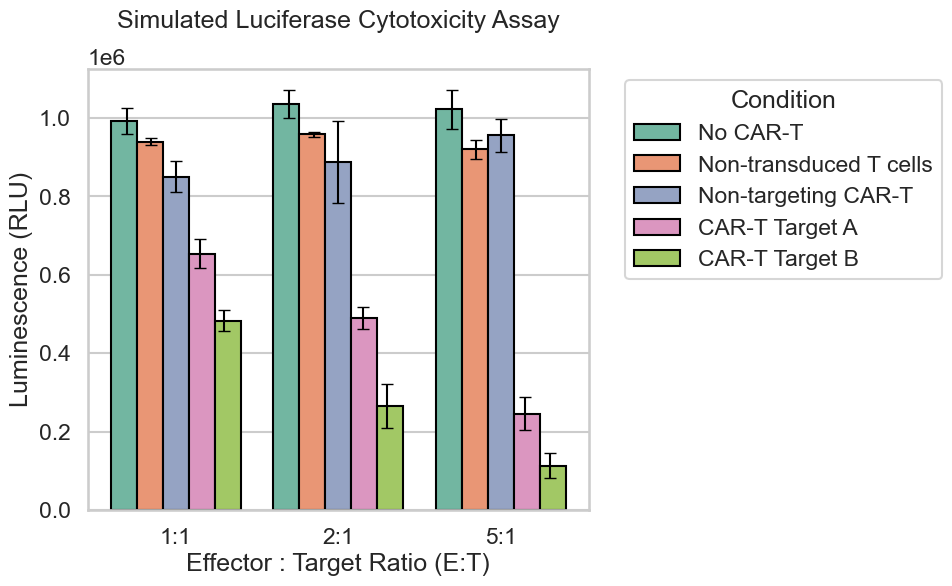

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define experimental design
ET_ratios = ["1:1", "2:1", "5:1"]
timepoints = ["6h", "24h"]
conditions = [
    "No CAR-T",
    "Non-transduced T cells",
    "Non-targeting CAR-T",
    "CAR-T Target A",
    "CAR-T Target B"
]

# Set random seed for reproducibility
np.random.seed(42)

# Simulate luminescence data
data = []
for time in timepoints:
    for et in ET_ratios:
        for cond in conditions:
            base_mean = 1.0e6  # baseline luminescence (no CAR-T)
            
            if cond == "No CAR-T":
                mean = base_mean
            elif cond == "Non-transduced T cells":
                mean = base_mean * np.random.uniform(0.9, 1.0)
            elif cond == "Non-targeting CAR-T":
                mean = base_mean * np.random.uniform(0.85, 0.95)
            elif cond == "CAR-T Target A":
                mean = base_mean * (0.8 if et == "1:1" else 0.6 if et == "2:1" else 0.3)
                mean *= 0.8 if time == "24h" else 1.0
            elif cond == "CAR-T Target B":
                mean = base_mean * (0.7 if et == "1:1" else 0.4 if et == "2:1" else 0.2)
                mean *= 0.75 if time == "24h" else 1.0
            
            values = np.random.normal(loc=mean, scale=0.05 * base_mean, size=3)
            for v in values:
                data.append([et, time, cond, v])

# Create tidy DataFrame
df = pd.DataFrame(data, columns=["E:T", "Timepoint", "Condition", "Luminescence"])

# Keep only one timepoint (e.g., 24 hours)
df = df[df["Timepoint"] == "24h"].copy()

# Ensure condition order is preserved
df["Condition"] = pd.Categorical(df["Condition"], categories=conditions, ordered=True)

# Compute means and SDs
summary = df.groupby(["E:T", "Condition"]).agg(
    mean_lum=("Luminescence", "mean"),
    sd_lum=("Luminescence", "std")
).reset_index()

# --- Plot ---
sns.set(style="whitegrid", context="talk")

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=summary,
    x="E:T",
    y="mean_lum",
    hue="Condition",
    ci=None,
    palette="Set2",
    edgecolor="black"
)

# Add error bars manually (± SD)
for i, row in summary.iterrows():
    et_index = list(summary["E:T"].unique()).index(row["E:T"])
    cond_index = conditions.index(row["Condition"])
    x = et_index + (cond_index - 2) * 0.15  # manual offset
    ax.errorbar(
        x=x, y=row["mean_lum"],
        yerr=row["sd_lum"],
        fmt="none", ecolor="black", capsize=4, lw=1.5
    )

plt.title("Simulated Luciferase Cytotoxicity Assay", pad=15)
plt.ylabel("Luminescence (RLU)")
plt.xlabel("Effector : Target Ratio (E:T)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Condition")
plt.tight_layout()
plt.show()
